# Prefiltering tutorial notebook

This notebook performs the prefiltering of the 4D-STEM dataset of the Au nanocrystal growth experiment in a liquid cell, as described in: 

XXXXX (paper)

Experimental data was collected by Serin Lee (serinl@stanford.edu) and Andrew Barnum(ajbarnum@stanford.edu).

This tutorial was created by: 
- Serin lee (serinl@stanford.edu)
- Stephanie Ribet (sribet@lbl.gov)
- Arthur McCray (amccray@stanford.edu)
- Colin Ophus (cophus@stanford.edu)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import cupy as cp 

dev_count = torch.cuda.device_count()
GPU_IND = 2
if dev_count == 0: 
    print("GPU not available, using cpu only")
    device = "cpu"
    cp = np 
else: 
    device = f"cuda:{GPU_IND}"
    print(f"Using GPU index {GPU_IND}")
    cp.cuda.Device(GPU_IND).use() 

print(torch.cuda.is_available())
print(torch.cuda.current_device())

Using GPU index 2
True
2


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import py4DSTEM as p4
import pymatgen
from scipy.ndimage import binary_erosion
from py4DSTEM.process.utils import tqdmnd
from scipy.ndimage import gaussian_filter
from py4DSTEM.process.utils.cluster import Cluster
from datetime import datetime
from pathlib import Path 
from cupyx.scipy.ndimage import gaussian_filter as cu_gaussian_filter
import h5py
from tqdm import tqdm
from skimage.filters import threshold_triangle
import scipy.ndimage as ndi 


cupyx.jit.rawkernel is experimental. The interface can change in the future.


# Example Dataset (Zenodo)

This tutorial uses a publicly available 4D-STEM dataset archived on Zenodo.

**Dataset DOI:**  
[10.5281/zenodo.18167694](https://doi.org/10.5281/zenodo.18167694) : Version v2
Please use the Version v2 of the data the Zenodo: file naming issue

**Title:**  
*4D-STEM dataset of Au nanoparticle in liquid cell TEM* (version 2)

**Description:**  
This dataset contains the raw and prefiltered 4D-STEM data used to demonstrate
the clustering workflow. It is intended for use with this tutorial notebook and the associated publication.

You can download the dataset automatically through the notebook (see code cell below),
or manually via the DOI link.

**How to cite this dataset:**  
If you use the data and the tutorial, please cite: XXX

In [4]:
print(np.__version__)
print(p4.__version__)

2.2.6
0.14.19


# Data Download

The following cell will automatically download the raw 4D-STEM dataset into a local `data/` folder
if it is not already present:
Due to the compressed acquisition format of the Dectris Arina detector, the raw 4D-STEM dataset consists of one master  file and 27 associated chunk files. These files must reside in the same directory for correct data access. To ensure data integrity and ease of use, the raw dataset is provided as a single ZIP archive.


In [7]:

import requests
import zipfile

data_dir = Path("data_test")
data_dir.mkdir(exist_ok=True)

zenodo_record_id = "18167694" 
zip_name = "Raw_4DSTEM_Au_nanoparticle_liquid_cell_TEM.zip"

zip_path = data_dir / zip_name
extract_dir = data_dir / "raw_data"


url = f"https://zenodo.org/records/{zenodo_record_id}/files/{zip_name}?download=1"

if not zip_path.exists():
    print(f"Downloading {zip_name}...")
    r = requests.get(url, stream=True)
    r.raise_for_status()
    with open(zip_path, "wb") as f:
        for chunk in r.iter_content(chunk_size=8192):
            if chunk:
                f.write(chunk)
    print("Download complete.")

if not extract_dir.exists():
    print(f"Extracting to {extract_dir}...")
    extract_dir.mkdir()
    with zipfile.ZipFile(zip_path, "r") as z:
        z.extractall(extract_dir)
    print("Extraction complete.")
else:
    print(f"Using existing extracted data at {extract_dir}")


Download complete.
Extracting to data_test/raw_data...
Extraction complete.


In [8]:
semiangle_convergence_mrad = 0.622
energy = 300e3

In [9]:
save_dir = data_dir / 'compressed_npz'
save_dir.mkdir(exist_ok=True)

In [10]:
raw_dir = extract_dir / 'Raw_4DSTEM_Au_nanoparticle_liquid_cell_TEM'
raw_dir.mkdir(exist_ok=True)

# Load the data

In [11]:
master_files = list(raw_dir.glob("*master*.h5"))

if len(master_files) != 1:
    raise RuntimeError(
        f"Expected exactly one master .h5 file, found {len(master_files)}: "
        f"{[f.name for f in master_files]}"
    )

master_file = master_files[0]

In [12]:
dataset=p4.import_file(
    master_file,
    filetype = "arina",
    scan_width = 512,
)

# Median filtering

In [14]:
dataset.get_dp_mean()

VirtualDiffraction( A 2-dimensional array of shape (192, 192) called 'dp_mean',
                    with dimensions:

                        dim0 = [0,1,2,...] pixels
                        dim1 = [0,1,2,...] pixels
)

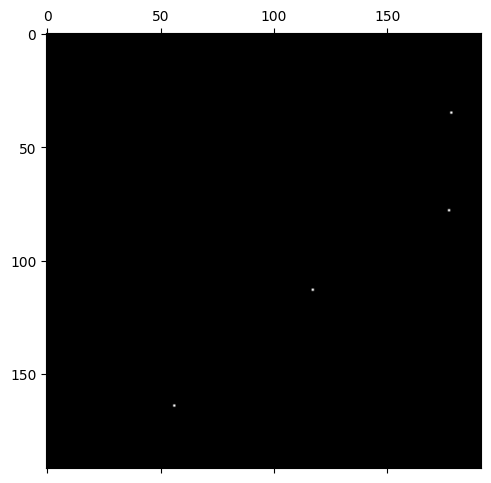

In [15]:
median_mask = dataset.tree('dp_mean').data > 6e4
p4.show(median_mask)


In [16]:
dataset=dataset.median_filter_masked_pixels(median_mask)

# Correlative Prefiltering

Setting prefiltering parameters

In [17]:

dtype = np.float32
corr_range = np.array((0.85, 0.95), dtype=np.float32)
edge = 12  
bound = 4
sigma = 3
batch_rows = 4


EPS = 1e-12  # FIX: global small epsilon for safe divisions
x = np.arange(dataset.shape[2]).astype('float')
y = np.arange(dataset.shape[3]).astype('float')
x -= np.mean(x)
y -= np.mean(y)
weight = np.sqrt(x[:,None]**2 + y[None,:]**2)
weight /= np.sqrt(dataset.shape[2]*dataset.shape[3])
weight **= 2
edge = 12
weight[:edge,:] = 0.0
weight[:,:edge] = 0.0
weight[-edge:,:] = 0.0
weight[:,-edge:] = 0.0

# FIX: NaN-guard + safe weight_sum (could be 0 if image is smaller than 2*edge)
weight = np.nan_to_num(weight, copy=False, nan=0.0, posinf=0.0, neginf=0.0)
weight_sum = float(np.sum(weight))
if weight_sum <= 0.0:
    # Fallback: uniform weights inside the non-edge region
    weight[...] = 0.0
    core = (slice(edge, max(dataset.shape[2] - edge, edge + 1)),
            slice(edge, max(dataset.shape[3] - edge, edge + 1)))
    weight[core] = 1.0
    weight_sum = float(np.sum(weight))
# Final clamp
weight_sum = max(weight_sum, EPS)


r = np.arange(-bound,bound+1)
yy,xx = np.meshgrid(r,r)
footprint = xx**2 + yy**2 <= (bound+0.5)**2
dx = xx[footprint]
dy = yy[footprint]



In [ ]:

ntime=datetime.now()
print("Starting gaussian filtering loop")

blurred = np.empty_like(dataset.data, dtype=np.float32)

for i0 in range(0, dataset.shape[0], batch_rows):
    i1 = min(i0 + batch_rows, dataset.shape[0])
    # Slice a small block (i0:i1, :, :, :)
    block = dataset.data[i0:i1].astype(np.float32, copy=False)

    # Move to GPU
    block_gpu = cp.asarray(block, order='C')  # shape (B, , Qx, Qy)

    # Use a simple boundary mode; 'nearest' or 'reflect' are typical. Match your CPU choice if needed.
    blurred_gpu = cu_gaussian_filter(block_gpu, sigma=(0, 0, sigma, sigma), mode='reflect')

    # Bring back to CPU
    blurred[i0:i1] = cp.asnumpy(blurred_gpu)

    # Clean up GPU memory between batches
    del block_gpu, blurred_gpu
    cp.get_default_memory_pool().free_all_blocks()
    cp.get_default_pinned_memory_pool().free_all_blocks()

print(f"finished guassian filtering loop: {datetime.now() - ntime}")

# prefiltering
ntime=datetime.now()
print("Starting prefiltering loop...")

blurred = np.nan_to_num(blurred, copy=False, nan=0.0, posinf=0.0, neginf=0.0)

data_new = np.zeros(dataset.data.shape, dtype='float32')  

# FIX: safe denominator for corr_range mapping
corr_den = float(corr_range[1] - corr_range[0])
corr_den = corr_den if abs(corr_den) > EPS else EPS


for rx, ry in tqdmnd(
    
    range(dataset.shape[0]),
    range(dataset.shape[1]),
):
    # ---- reference tile ----
    im0 = blurred[rx,ry]

    # weighted, mean-removed
    wmean0 = np.sum(im0 * weight) / weight_sum   # FIX: safe weight_sum
    im0 = (im0 - wmean0) * weight

    # FIX: safe L2 normalization
    norm0 = float(np.sqrt(np.sum(im0**2)))
    im0 /= max(norm0, EPS)

    corr = np.zeros(dx.size, dtype=float)

    # ---- neighbors ----
    for ind in range(dx.size):
        xt = rx + dx[ind]
        yt = ry + dy[ind]

        if (xt >= 1) and (yt >= 1) and (xt < dataset.shape[0]) and (yt < dataset.shape[1]):
            im1 =blurred[xt, yt]
            wmean1 = np.sum(im1 * weight) / weight_sum     # FIX: safe weight_sum
            im1 = (im1 - wmean1) * weight
            norm1 = float(np.sqrt(np.sum(im1**2)))         # FIX: safe L2 normalization
            im1 /= max(norm1, EPS)

            # dot-product correlation (safe because im0, im1 are finite & normalized)
            corr[ind] = np.sum(im0 * im1)

    # map corr into [0,1] using corr_range, with safe denominator
    corr = (corr - corr_range[0]) / corr_den
    corr = np.clip(corr, 0.0, 1.0)

    # ---- accumulate filtered output ----
    data_new[rx, ry] = dataset.data[rx, ry]
    for ind in range(dx.size):
        if corr[ind] > 1e-3:
            xt = rx + dx[ind]
            yt = ry + dy[ind]
            data_new[rx, ry] += dataset.data[xt, yt] * corr[ind]

    # FIX: denominator is already safe ( +1 ), but make sure corr sum is finite
    corr_sum = float(np.sum(corr))
    if not np.isfinite(corr_sum):
        corr_sum = 0.0
    data_new[rx, ry] /= (corr_sum + 1.0)
print(f"finished prefiltering loop: {datetime.now() - ntime}")

# saving as compressed h5 file
ntime=datetime.now()
print("Starting npz compressing loop...")

arr = data_new
# Step 1: normalize into [0, 1]
arr_min, arr_max = float(arr.min()), float(arr.max())
if arr_max > arr_min:
    arr_norm = (arr - arr_min) / (arr_max - arr_min)
else:
    arr_norm = np.zeros_like(arr, dtype=np.float32)

# Step 2: scale to 0–65535 and cast to uint16
arr_uint16 = (arr_norm * 65535).astype(np.uint16)

print(f"finished compressing loop: {datetime.now() - ntime}")    



# Save the npz dataset

In [ ]:
np.savez_compressed(save_dir/f"Prefiltered_4DSTEM_Au_nanoparticle_liquid_cell.npz", data=arr_uint16)